In [1]:
#install hugging face
# pip install transformers

# pip install scipy

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [4]:
df = pd.read_csv('C:/Users/lavat/Documents/TheForage/BristishAirways/data/BA_rate_reviews.csv')

In [5]:
# df.index.names = ['id']
df["id"] = df.index + 1

In [6]:
df.head()

,reviews,rating,id
0,✅ Trip Verified | First our morning flight wa...,1,1
1,✅ Trip Verified | Although it was a bit uncom...,8,2
2,✅ Trip Verified | Boarding was decently organ...,6,3
3,✅ Trip Verified | Boarding on time and departu...,7,4
4,✅ Trip Verified | My original flight was canc...,1,5


In [7]:
clean_df = df

In [8]:
clean_df['reviews'] = df['reviews'].str.replace('✅ Trip Verified', '')
clean_df['reviews'] = df['reviews'].str.replace('Not Verified', '')
clean_df['reviews'] = df['reviews'].str.replace('|', '')
clean_df['reviews'] = df['reviews'].str.replace(',', '')
clean_df['reviews'] = df['reviews'].str.replace('.', '')
clean_df['reviews'] = df['reviews'].str.replace('!', '')
clean_df.head()

C:\Users\lavat\AppData\Local\Temp\ipykernel_22136\2736150750.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  clean_df['reviews'] = df['reviews'].str.replace('|', '')
C:\Users\lavat\AppData\Local\Temp\ipykernel_22136\2736150750.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  clean_df['reviews'] = df['reviews'].str.replace('.', '')


,reviews,rating,id
0,First our morning flight was cancelled and ...,1,1
1,Although it was a bit uncomfortable flight ...,8,2
2,Boarding was decently organised The A380 st...,6,3
3,Boarding on time and departure on time for a...,7,4
4,My original flight was cancelled just over ...,1,5


##### Vader Sentiment Scoring
###### uses NLTK's Sentiment intensity analyzer to get negative/neutral/positive scores of the text
###### uses a bag of words approach
###### removes stop words first then each word is scored and combined to a total score

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
# from tqdm.notebook import tqdm
from tqdm import tqdm
# create analyzer object
sia = SentimentIntensityAnalyzer()

In [10]:
# from ipywidgets import FloatProgress

In [11]:
# Run polarity score on dataset, grab polarity score of each review by looping. Store it in dictionary by id
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['reviews']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

100%|██████████| 300/300 [00:00<00:00, 650.22it/s]


In [12]:
# visualize res results as dataframe for easy readability, use .T to transpose
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'id'}) 
vaders = vaders.merge(df, how='left') # left merge to original df, reference common column index:id

In [13]:
# sentiment score is presented alongside meta data
vaders.head()

,id,neg,neu,pos,compound,reviews,rating
0,1,0.092,0.874,0.034,-0.7960,First our morning flight was cancelled and ...,1
1,2,0.067,0.751,0.181,0.6597,Although it was a bit uncomfortable flight ...,8
2,3,0.104,0.747,0.149,0.7104,Boarding was decently organised The A380 st...,6
3,4,0.000,0.796,0.204,0.8895,Boarding on time and departure on time for a...,7
4,5,0.076,0.761,0.163,0.6249,My original flight was cancelled just over ...,1


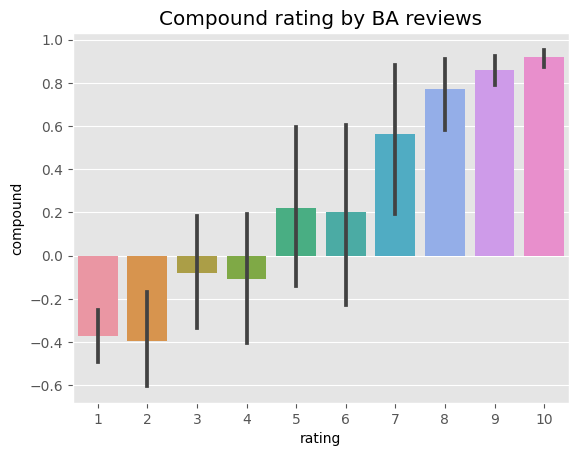

In [14]:
ax = sns.barplot(data=vaders, x= 'rating', y='compound')
ax.set_title('Compound rating by BA reviews')
plt.show()

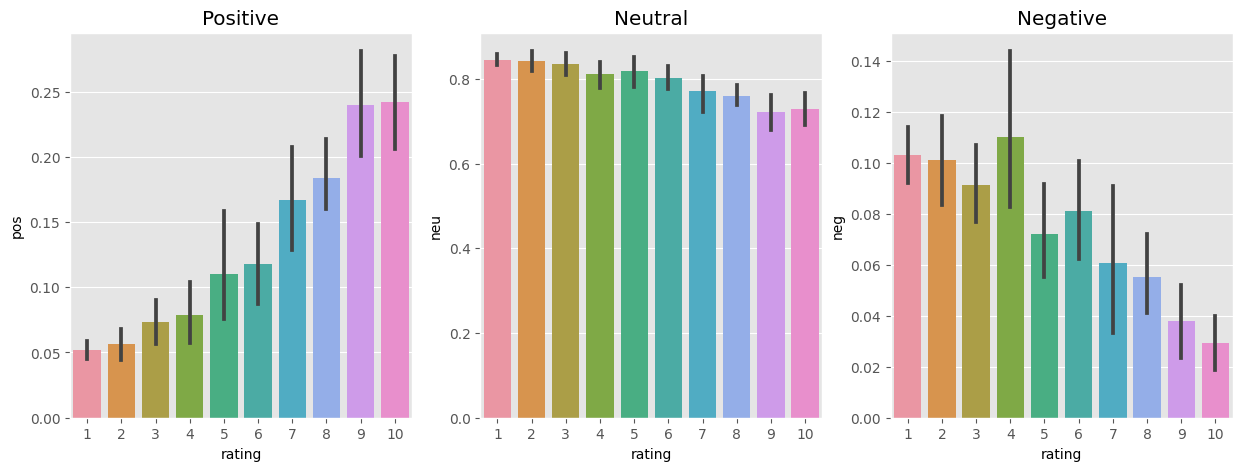

In [15]:
# make a 1 by 3 plot grid to show the three sentiment range bar plot
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
sns.barplot(data =vaders, x='rating', y='pos', ax = axs[0])
sns.barplot(data =vaders, x='rating', y='neu', ax = axs[1])
sns.barplot(data =vaders, x='rating', y='neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

plt.show()

#### Roberta pretrained models picks up on context to evaluate words 

In [16]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [17]:
# pull model weight stored from specific pretrained model on twitter data for sentiment from hugging face
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [18]:
# run data in roberta model by firstly encoding text using a function
def polarity_scores_roberta(review):
    encoded_text = tokenizer(review, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [19]:
# iterate function through dataset
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):

    try:
        text = row['reviews']
        myid = row['id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value

        roberta_result = polarity_scores_roberta(text)

        # combine both results into dictionary
        both = {**vader_result_rename, **roberta_result}
        #store into dictionary
        res[myid] = both

# handle bug when text size is too big
    except RuntimeError:
        print(f'Broke for id {myid}')
        
        # break      -- add break to test out first iteration sample

  3%|▎         | 10/300 [00:01<01:01,  4.74it/s]

Broke for id 9


 10%|█         | 31/300 [00:10<01:58,  2.26it/s]

Broke for id 32


 14%|█▎        | 41/300 [00:12<00:42,  6.06it/s]

Broke for id 40


 67%|██████▋   | 202/300 [01:11<00:37,  2.61it/s]

Broke for id 203


 87%|████████▋ | 261/300 [01:35<00:12,  3.19it/s]

Broke for id 262


 94%|█████████▍| 283/300 [01:41<00:04,  4.18it/s]

Broke for id 284


100%|██████████| 300/300 [01:46<00:00,  2.81it/s]


In [20]:
#visualize results in a dataframe for legibility
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'id'}) 
results_df = results_df.merge(df, how='left') # left merge to original df, reference common column index:id

In [21]:
results_df.head()

,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,reviews,rating
0,1,0.092,0.874,0.034,-0.7960,0.747004,0.226707,0.026289,First our morning flight was cancelled and ...,1
1,2,0.067,0.751,0.181,0.6597,0.022951,0.105064,0.871985,Although it was a bit uncomfortable flight ...,8
2,3,0.104,0.747,0.149,0.7104,0.127457,0.404031,0.468513,Boarding was decently organised The A380 st...,6
3,4,0.000,0.796,0.204,0.8895,0.006514,0.080457,0.913029,Boarding on time and departure on time for a...,7
4,5,0.076,0.761,0.163,0.6249,0.562783,0.374600,0.062617,My original flight was cancelled just over ...,1


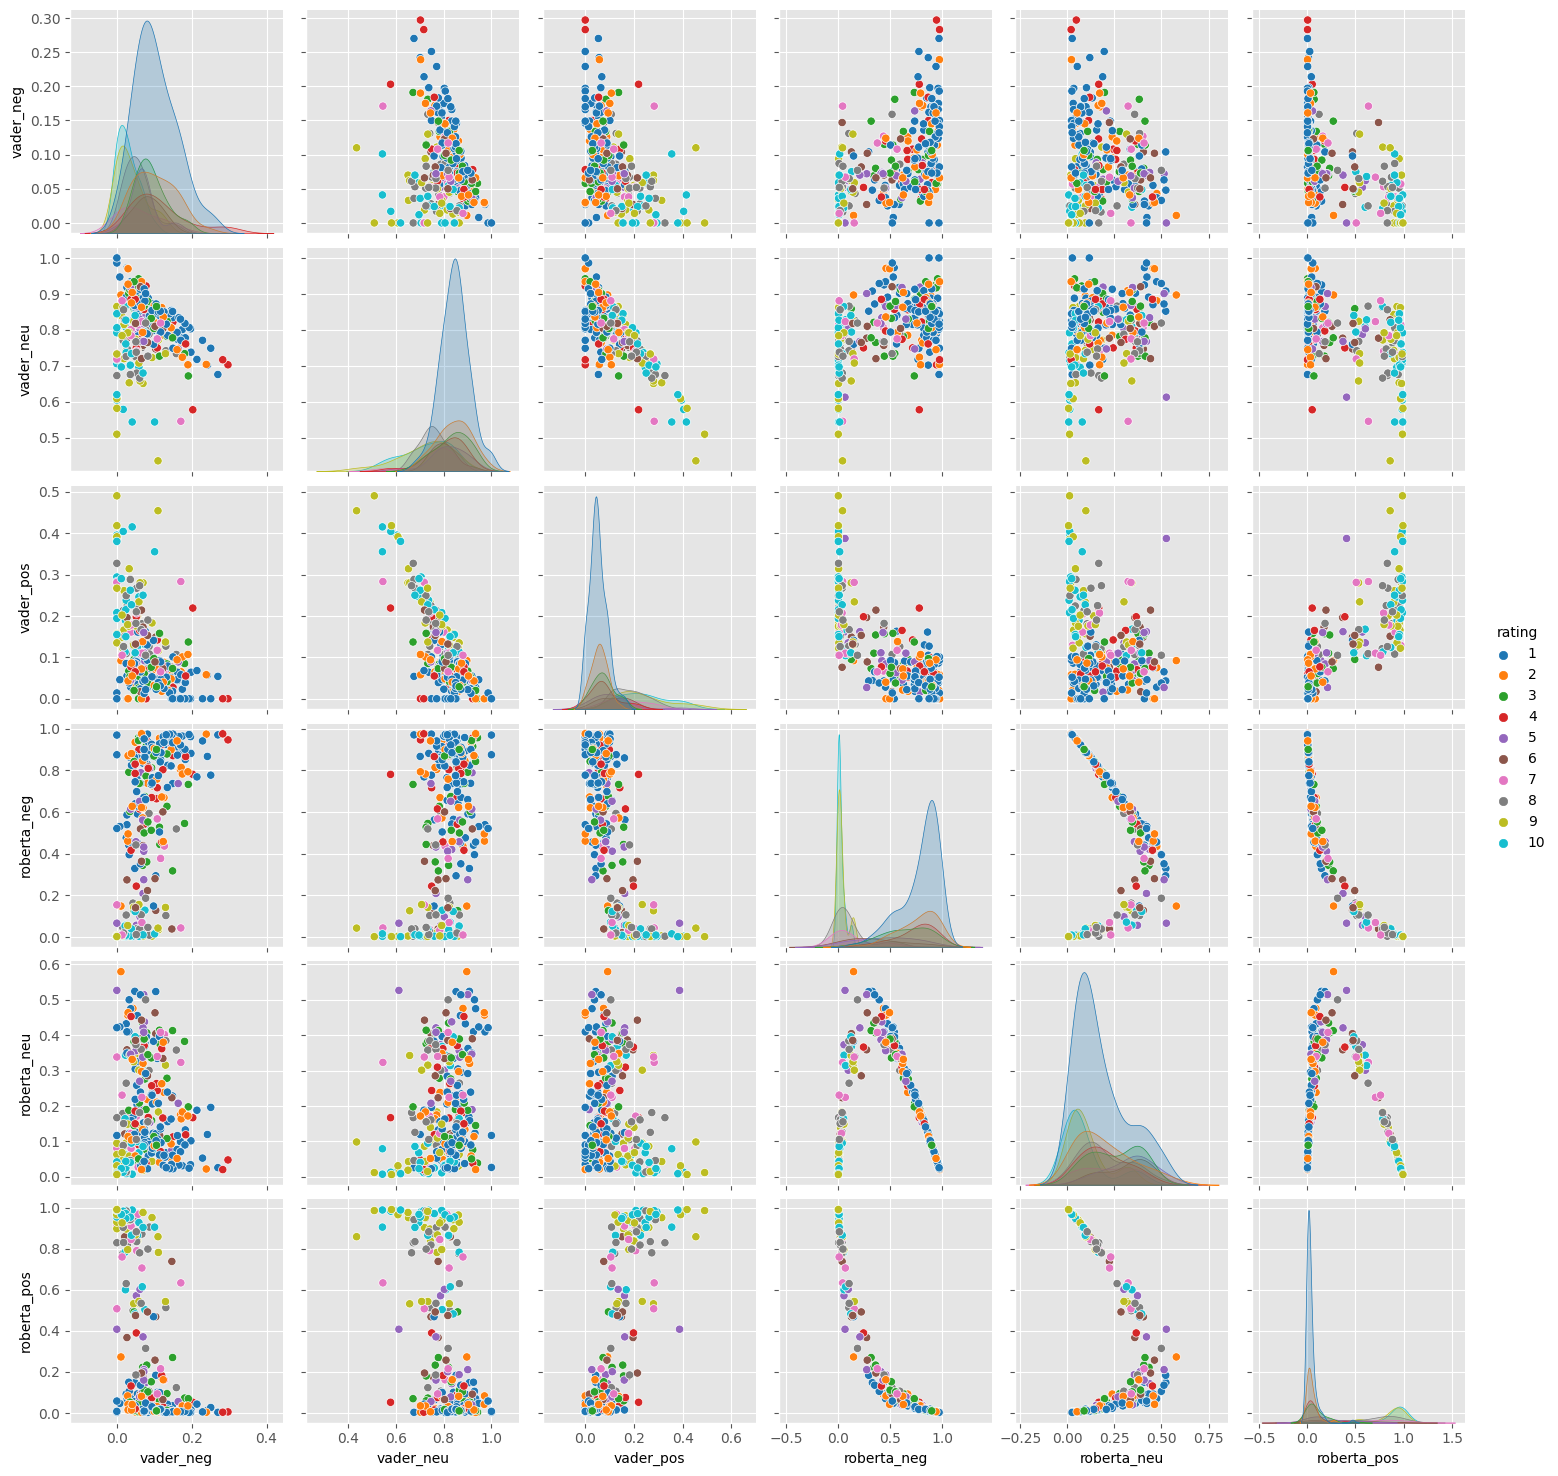

In [22]:
# Compare both models vader and roberta results via sns plot
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
                  hue= "rating",
                  palette='tab10')
plt.show()

In [23]:
# see mean values for positive, neutral and negative reviews
results_df.describe()

,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,rating
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,150.748299,0.081908,0.806844,0.111279,0.087229,0.517162,0.191795,0.291043,4.251701
std,86.072265,0.057228,0.086379,0.095647,0.774256,0.364570,0.144406,0.370095,3.283725
min,1.000000,0.000000,0.436000,0.000000,-0.993800,0.001317,0.006592,0.002293,1.000000
25%,77.250000,0.041000,0.764250,0.046000,-0.767775,0.077397,0.068227,0.014404,1.000000
50%,150.500000,0.072000,0.819000,0.083500,0.238950,0.601905,0.153356,0.064544,3.000000
75%,224.750000,0.114750,0.863000,0.156500,0.889500,0.867142,0.324405,0.593114,8.000000
max,300.000000,0.297000,1.000000,0.490000,0.995700,0.976671,0.578924,0.991579,10.000000


#### Ignore, math does not add up too 100%. The mean calculation shows already that 51% reviews are negative, 29% positive and 19% neutral

In [32]:
# count number of negative, positive and neutral reviews
num_neg = []
for row in results_df['roberta_neg']:
    if row >= 0.5:
        num_neg.append(row)

print("Percent of negative reviews: ", (len(num_neg))/300*100)

Percent of negative reviews:  56.00000000000001


In [31]:
num_neu = []
for score in results_df['roberta_neu']:
    if score >= 0.5:
        num_neu.append(score)


print('Percent neutral reviews: ', (len(num_neu))/300*100)

Percent neutral reviews:  2.0


In [29]:
num_pos = []

for score in results_df['roberta_pos']:
    if score >= 0.5:
        num_pos.append(score)

print('Percent positive reviews: ', (len(num_pos))/300*100)

Percent positive reviews:  27.666666666666668
